In [1]:
using Revise
using ForneyLab, Random, Plots, LinearAlgebra, DelimitedFiles
using ForneyLab: unsafeMean

In [2]:
Random.seed!(1234);

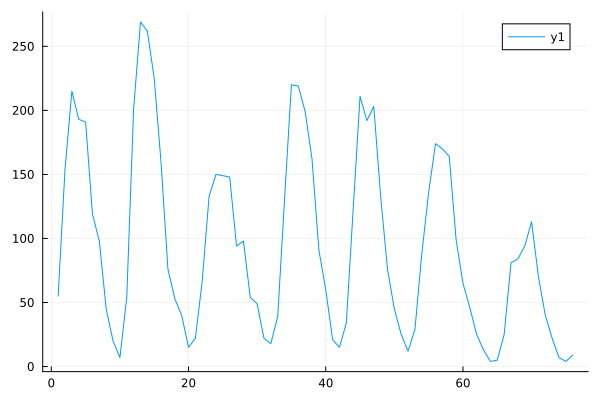

In [3]:
sunspot = readdlm("data/SN_y_tot_V2.0.csv", ';')
select_1945_2020 = filter((s) -> s[1] > 1945 && s[1] < 2021, collect(eachrow(sunspot)))
dataset = map((s) -> round(s[2]), select_1945_2020)
plot(dataset)


In [4]:
N = length(dataset);

In [5]:
# Model specification
graph = FactorGraph()

f(z) = z

@RV b ~ Gamma(1000., 1.) # Shape-Rate parameterization in ForneyLab
a = Vector{Variable}(undef, N)
x = Vector{Variable}(undef, N-1)
y = Vector{Variable}(undef, N)
@RV a[1] ~ Gamma(1., b)
@RV y[1] ~ Poisson(a[1])
placeholder(y[1], :y, index=1)

for i=2:N
    @RV x[i-1] ~ Aismp(a[i-1],g=f)
    @RV a[i] ~ Gamma(x[i-1],b)
    @RV y[i] ~ Poisson(a[i]) 
    
    placeholder(y[i], :y, index=i)
end

In [6]:
# Specify factorizations in recognition distribution
pfz = PosteriorFactorization()

q_b = PosteriorFactor(b, id=:b)
q_a = Vector{PosteriorFactor}(undef, N)
for t=1:N
    q_a[t] = PosteriorFactor(a[t],id=:a_*t)
end

algo_mf = messagePassingAlgorithm(id=:MF, free_energy=true)

# Generate source code
code_mf = algorithmSourceCode(algo_mf, free_energy=true);
eval(Meta.parse(code_mf));

In [13]:
n_its = 10
data = Dict(:y => dataset)
marginals = Dict()

marginals[:b] = ProbabilityDistribution(Univariate, Gamma, a=1, b=1)
for n=1:N
    marginals[:a_*n] = ProbabilityDistribution(Univariate, Gamma, a=1, b=1)
end
for n=1:N-1
    marginals[:x_*n] = ProbabilityDistribution(Univariate, Gamma, a=1, b=1)
end

F = []
# Run algorithm
for i = 1:n_its
    stepMFb!(data, marginals)
    for t = 1:N
        step!(:MFa_*t, data, marginals)
    end
    push!(F, freeEnergyMF(data, marginals))
end
;

In [14]:
F

10-element Vector{Any}:
  7730.994120333946
 -2801.817987993629
 -6151.398903410425
 -6772.995126710976
 -6912.771771103331
 -6947.479303678611
 -6956.275793328407
 -6957.959063617768
 -6959.279363626521
 -6958.263586899263

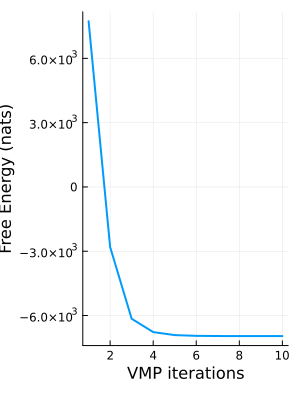

In [15]:
plot(F, legend=false, lw=2,size=(300,400), xlabel="VMP iterations", ylabel="Free Energy (nats)")

In [10]:
mean_list = []
var_list = []
for n=1:N
    push!(mean_list, mean(marginals[:a_*n]))
    push!(var_list, var(marginals[:a_*n]))
end

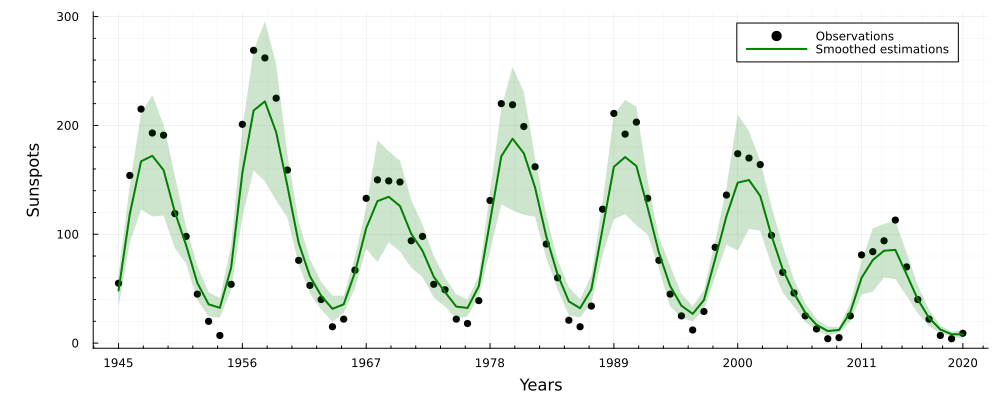

In [11]:
scatter(collect(1:N),dataset,color=:black,size=(900,200),legend=:topright, 
        xtick=([1, 12, 23, 34, 45, 56, 67, 76], [1945, 1956, 1967, 1978, 1989, 2000, 2011, 2020]), 
        xlabel="Years", ylabel="Sunspots", label="Observations", left_margin = 10Plots.mm, bottom_margin = 5Plots.mm)
plot!(mean_list,ribbon=var_list,label="Smoothed estimations", lw=2, size=(1000,400),color=:green,fillalpha=0.2)
xgrid!(minorgrid=:true)
ygrid!(minorgrid=:true)